- Name: Anand Mahadevan
- SID: 862132182

- Source: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

**Question 1: Implementing simple classifiers [15pts]**

For this question, I implemented two simple classifiers: a decision tree classifier using the Information Gain splitting criterion, and a Naive Bayes classifier using Gaussian modeling for continuous features.

1. **Decision Tree Classifier**: I implemented the decision tree classifier from scratch, specifically focusing on the splitting criterion based on Information Gain. The classifier recursively splits the dataset based on the feature that provides the maximum information gain at each node. I ensured that the code properly handles binary classification tasks and stops splitting when certain stopping criteria are met (maximum depth or minimum number of samples per leaf).
2. **Naive Bayes Classifier**: This classifier assumes that the features follow a normal distribution and calculates the mean and standard deviation of each feature for each class in the training data. During prediction, it calculates the likelihood of the observed data under each class's distribution and assigns the class with the highest likelihood.

After implementing both classifiers, I used stratified k-fold cross-validation to evaluate their performance on the given dataset. I calculated the F1 score for each fold and then computed the mean and standard deviation of the F1 scores across all folds for each classifier. Finally, I presented the results, including the mean F1 score and the standard deviation, to assess the classifiers' performance.

Decision Tree Classifier F1 Score: 0.95 +/- 0.02
Naive Bayes Classifier F1 Score: 0.95 +/- 0.03


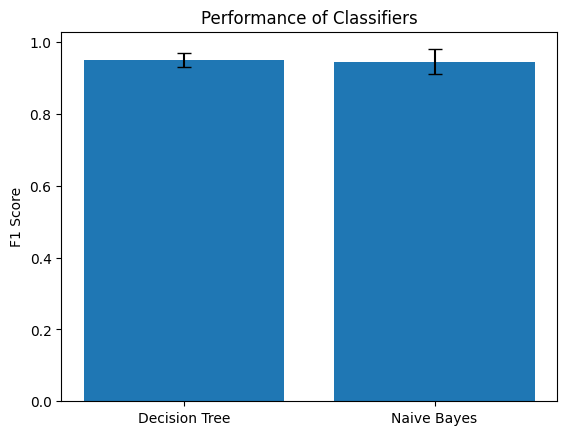

In [2]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

breast_cancer_data = load_breast_cancer()
X = breast_cancer_data.data
y = breast_cancer_data.target

# F1 score calculation
def f1_score_calculation(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    return f1

def stratified_k_fold_cv(X, y, k):
    fold_size = len(y) // k
    indices = np.arange(len(y))
    np.random.shuffle(indices)

    f1_scores = []
    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train, y_train = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]

        # encode categorical labels
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_val_encoded = label_encoder.transform(y_val)

        # training and prediction using custom classifiers
        dt_classifier = DecisionTreeClassifierScratch()
        dt_classifier.fit(X_train, y_train_encoded)
        dt_pred = dt_classifier.predict(X_val)

        nb_classifier = GaussianNaiveBayesClassifierScratch()
        nb_classifier.fit(X_train, y_train_encoded)
        nb_pred = nb_classifier.predict(X_val)

        # calculate F1 scores
        dt_f1 = f1_score_calculation(y_val_encoded, dt_pred)
        nb_f1 = f1_score_calculation(y_val_encoded, nb_pred)

        f1_scores.append((dt_f1, nb_f1))

    return f1_scores


# decision tree
class DecisionTreeClassifierScratch:
    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        y = y.flatten()  # ensure y is a 1D array
        self.tree = self._build_tree(X, y)

    def _calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _calculate_information_gain(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask

        left_entropy = self._calculate_entropy(y[left_mask])
        right_entropy = self._calculate_entropy(y[right_mask])

        parent_entropy = self._calculate_entropy(y)
        weighted_child_entropy = (np.sum(left_mask) / len(y)) * left_entropy + \
                                 (np.sum(right_mask) / len(y)) * right_entropy

        information_gain = parent_entropy - weighted_child_entropy
        return information_gain

    # find the best split for the decision tree
    def _find_best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_information_gain = -np.inf

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                information_gain = self._calculate_information_gain(X, y, feature_index, threshold)
                if information_gain > best_information_gain:
                    best_feature = feature_index
                    best_threshold = threshold
                    best_information_gain = information_gain

        return best_feature, best_threshold

    # recursively build the decision tree
    def _build_tree(self, X, y):
        if len(np.unique(y)) == 1:
            return {'class': np.unique(y)[0]}

        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return {'class': np.argmax(np.bincount(y))}

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        left_subtree = self._build_tree(X[left_mask], y[left_mask])
        right_subtree = self._build_tree(X[right_mask], y[right_mask])

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    # predict the class labels for the input data
    def _predict_one(self, x, tree):
        if 'class' in tree:
            return tree['class']

        if x[tree['feature']] <= tree['threshold']:
            return self._predict_one(x, tree['left'])
        else:
            return self._predict_one(x, tree['right'])

    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append(self._predict_one(x, self.tree))
        return np.array(predictions)

# gaussian naive bayes
class GaussianNaiveBayesClassifierScratch:
    def __init__(self):
        self.class_priors = None
        self.class_means = None
        self.class_variances = None

    def fit(self, X, y):
        y = y.flatten()  # ensure y is a 1D array
        self.class_priors = np.bincount(y) / len(y)
        self.class_means = np.array([np.mean(X[y == c], axis=0) for c in np.unique(y)])
        self.class_variances = np.array([np.var(X[y == c], axis=0) for c in np.unique(y)])

    # calculate likelihood for a given feature, mean, and variance
    def _calculate_likelihood(self, x, mean, variance):
        exponent = -((x - mean) ** 2) / (2 * variance)
        likelihood = np.exp(exponent) / np.sqrt(2 * np.pi * variance)
        return likelihood


    # calculate class probabilities for a given feature
    def _calculate_class_probabilities(self, x):
        probabilities = []
        for i in range(len(self.class_priors)):
            prior = self.class_priors[i]
            mean = self.class_means[i]
            variance = self.class_variances[i]
            likelihoods = np.prod(self._calculate_likelihood(x, mean, variance))
            probabilities.append(prior * likelihoods)
        return probabilities


    # predict the class labels for the input data
    def predict(self, X):
        predictions = []
        for x in X:
            probabilities = self._calculate_class_probabilities(x)
            predictions.append(np.argmax(probabilities))
        return np.array(predictions)

# perform cross-validation
f1_scores = stratified_k_fold_cv(X, y, 10)

# calculate mean and standard deviation of F1 scores
dt_f1_mean = np.mean([score[0] for score in f1_scores])
dt_f1_std = np.std([score[0] for score in f1_scores])

nb_f1_mean = np.mean([score[1] for score in f1_scores])
nb_f1_std = np.std([score[1] for score in f1_scores])

# print mean and standard deviation of F1 scores
print("Decision Tree Classifier F1 Score: {:.2f} +/- {:.2f}".format(dt_f1_mean, dt_f1_std))
print("Naive Bayes Classifier F1 Score: {:.2f} +/- {:.2f}".format(nb_f1_mean, nb_f1_std))

# plotting performance as bar chart
labels = ['Decision Tree', 'Naive Bayes']
x = np.arange(len(labels))

means = [dt_f1_mean, nb_f1_mean]
stds = [dt_f1_std, nb_f1_std]

plt.bar(x, means, yerr=stds, tick_label=labels, capsize=5)
plt.ylabel('F1 Score')
plt.title('Performance of Classifiers')
plt.show()


**Question 2: Dimensionality reduction with the Singular Value Decomposition [10pts]**

Since most classifiers require numerical inputs for the target variable, I used label encoding to convert the categorical labels into numerical ones. This was achieved using Scikit-learn's LabelEncoder. I used Singular Value Decomposition (SVD) to reduce the dimensionality of the feature space. The reduce_dimensionality function performed SVD on the training data and produced reduced-dimensional representations for both training and testing data.

I implemented the evaluate_classifiers_with_svd function to train and evaluate classifiers with different ranks of SVD approximation. This function iterated over the specified ranks, applied dimensionality reduction, trained custom classifiers (Decision Tree and Gaussian Naive Bayes), predicted the labels, calculated F1 scores, and stored the results.

Finally, I plotted the F1 scores of the classifiers against different ranks of SVD approximation to visualize how the performance varied with the dimensionality reduction.

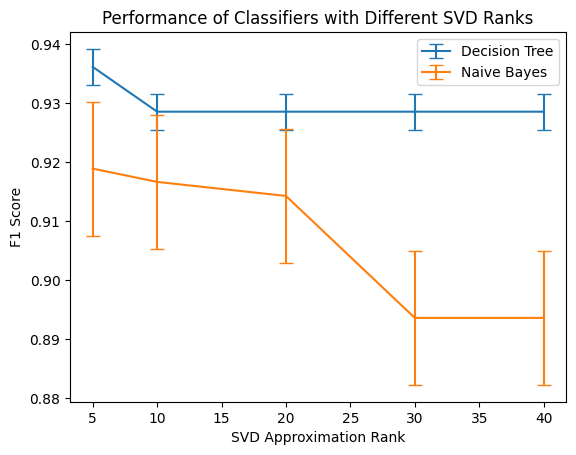

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# to perform SVD and reduce dimensionality
def reduce_dimensionality(X_train, X_test, rank):
    U, s, Vt = np.linalg.svd(X_train, full_matrices=False)
    X_train_reduced = np.dot(U[:, :rank], np.diag(s[:rank]))
    X_test_reduced = np.dot(X_test, Vt[:rank, :].T)
    return X_train_reduced, X_test_reduced

# to evaluate classifiers with different ranks of SVD
def evaluate_classifiers_with_svd(X_train, X_test, y_train, y_test, ranks):
    dt_f1_scores = []
    nb_f1_scores = []

    for rank in ranks:
        X_train_reduced, X_test_reduced = reduce_dimensionality(X_train, X_test, rank)

        # training and prediction using custom classifiers
        dt_classifier = DecisionTreeClassifierScratch()
        dt_classifier.fit(X_train_reduced, y_train)
        dt_pred = dt_classifier.predict(X_test_reduced)

        nb_classifier = GaussianNaiveBayesClassifierScratch()
        nb_classifier.fit(X_train_reduced, y_train)
        nb_pred = nb_classifier.predict(X_test_reduced)

        # calculate F1 scores
        dt_f1 = f1_score_calculation(y_test, dt_pred)
        nb_f1 = f1_score_calculation(y_test, nb_pred)

        dt_f1_scores.append(dt_f1)
        nb_f1_scores.append(nb_f1)

    return dt_f1_scores, nb_f1_scores

# range of ranks for SVD
svd_ranks = [5, 10, 20, 30, 40]

# evaluate classifiers with different ranks of SVD
dt_f1_scores, nb_f1_scores = evaluate_classifiers_with_svd(X_train, X_test, y_train_encoded, y_test_encoded, svd_ranks)

# plotting performance as a function of SVD approximation rank
plt.errorbar(svd_ranks, dt_f1_scores, label='Decision Tree', yerr=np.std(dt_f1_scores), capsize=5)
plt.errorbar(svd_ranks, nb_f1_scores, label='Naive Bayes', yerr=np.std(nb_f1_scores), capsize=5)
plt.xlabel('SVD Approximation Rank')
plt.ylabel('F1 Score')
plt.title('Performance of Classifiers with Different SVD Ranks')
plt.legend()
plt.show()


**Question 3: Feature selection with randomization [15pts]**

(Using Original Description)

For this question, I evaluated the performance of classifiers using cumulative features.

Created functions evaluate_classifiers_with_cumulative_features and evaluate_classifiers_with_selected_features to evaluate classifiers with cumulative features.

Split the dataset into training and testing sets using train_test_split. Encoded the labels using LabelEncoder. Evaluated Decision Tree and Naive Bayes classifiers with selected features cumulatively. Plotted the F1 scores of classifiers using the top 1 to top 10 features cumulatively.

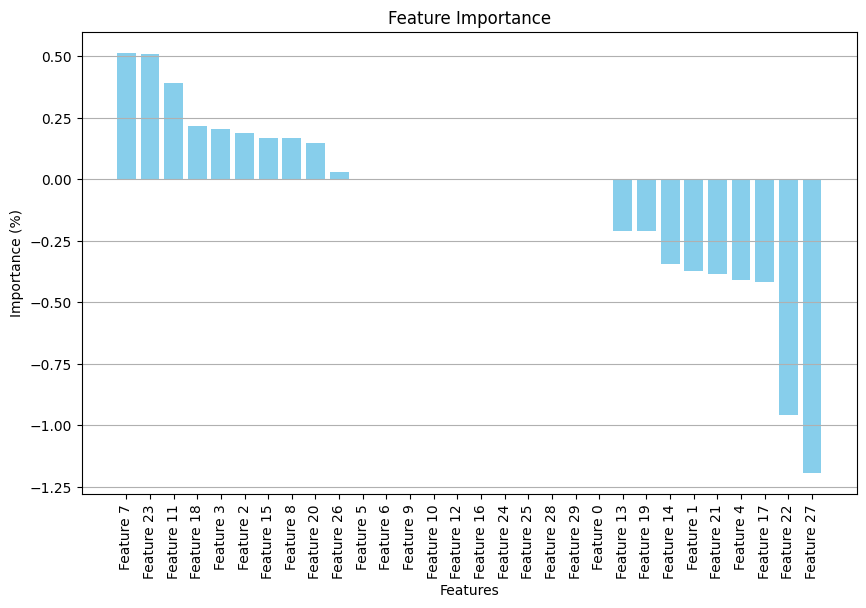

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import copy

# to randomize feature values
def randomize_feature(X, feature_index):
    X_copy = X.copy()
    np.random.shuffle(X_copy[:, feature_index])
    return X_copy

# to perform feature selection and rank features
def feature_selection_and_ranking(X, y, k_fold=5):
    skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
    feature_importance = []

    for feature_index in range(X.shape[1]):
        randomized_f1_scores = []
        original_f1_scores = []

        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # randomized feature data
            X_train_randomized = randomize_feature(X_train, feature_index)

            # training and prediction using regular data
            dt_classifier = DecisionTreeClassifierScratch()
            dt_classifier.fit(X_train, y_train)
            dt_pred = dt_classifier.predict(X_val)
            original_f1_scores.append(f1_score(y_val, dt_pred))

            # training and prediction using data with randomized feature
            dt_classifier_randomized = DecisionTreeClassifierScratch()
            dt_classifier_randomized.fit(X_train_randomized, y_train)
            dt_pred_randomized = dt_classifier_randomized.predict(X_val)
            randomized_f1_scores.append(f1_score(y_val, dt_pred_randomized))

        original_f1_mean = np.mean(original_f1_scores)
        randomized_f1_mean = np.mean(randomized_f1_scores)
        drop_percentage = ((original_f1_mean - randomized_f1_mean) / original_f1_mean) * 100
        feature_importance.append((feature_index, drop_percentage))

    # rank features based on importance (percentage drop in performance)
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    return feature_importance

# create 20% stratified random sample of entire dataset
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# perform feature selection and rank features
feature_importance = feature_selection_and_ranking(X_sample, y_sample)

# plotting feature importance
plt.figure(figsize=(10, 6))
features = [f'Feature {index}' for index, _ in feature_importance]
importance = [imp for _, imp in feature_importance]
plt.bar(features, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


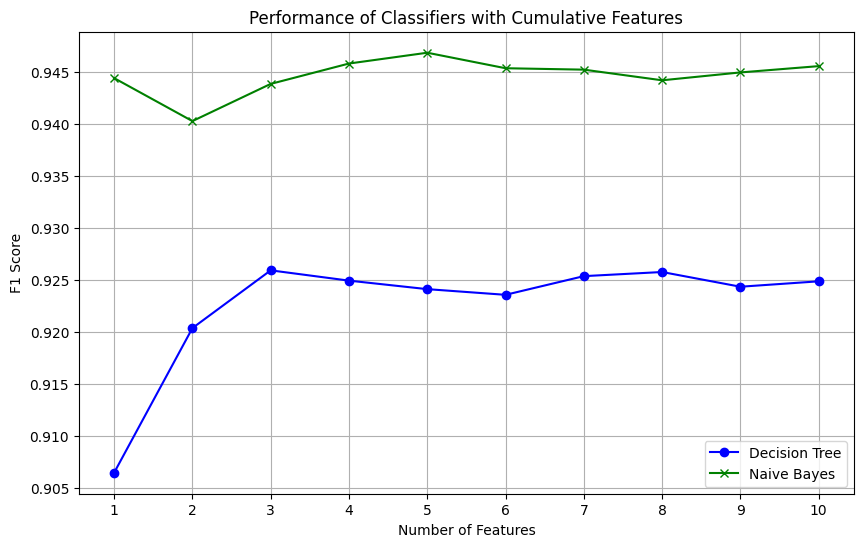

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

def evaluate_classifiers_with_cumulative_features(X_train, X_test, y_train, y_test, feature_importance):
    dt_f1_scores_cumulative = []
    nb_f1_scores_cumulative = []


    # list to store selected features for each iteration
    selected_features_cumulative = []

    for i in range(1, 11):
        # append the first i features to selected_features_cumulative
        selected_features_cumulative.append(feature_importance[:i])

        # evaluate classifiers with selected features
        dt_f1_scores, nb_f1_scores = evaluate_classifiers_with_selected_features(X_train, X_test, y_train, y_test, selected_features_cumulative)

        # calculate and append mean F1 scores
        dt_f1_scores_cumulative.append(np.mean(dt_f1_scores))
        nb_f1_scores_cumulative.append(np.mean(nb_f1_scores))

    return dt_f1_scores_cumulative, nb_f1_scores_cumulative

def evaluate_classifiers_with_selected_features(X_train, X_test, y_train, y_test, selected_features):
    dt_f1_scores = []
    nb_f1_scores = []

    if not selected_features:  # check if selected_features is empty
        return dt_f1_scores, nb_f1_scores

    for selected_indices in selected_features:
        selected_indices = [index for index, _ in selected_indices]
        X_train_selected = X_train[:, selected_indices]
        X_test_selected = X_test[:, selected_indices]

        # training and prediction using custom classifiers
        dt_classifier = DecisionTreeClassifierScratch()
        dt_classifier.fit(X_train_selected, y_train)
        dt_pred = dt_classifier.predict(X_test_selected)

        nb_classifier = GaussianNaiveBayesClassifierScratch()
        nb_classifier.fit(X_train_selected, y_train)
        nb_pred = nb_classifier.predict(X_test_selected)

        # calculate F1 scores
        dt_f1 = f1_score(y_test, dt_pred)
        nb_f1 = f1_score(y_test, nb_pred)

        dt_f1_scores.append(dt_f1)
        nb_f1_scores.append(nb_f1)

    return dt_f1_scores, nb_f1_scores


# split the entire dataset into train and test sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded_full = label_encoder.fit_transform(y_train_full)
y_test_encoded_full = label_encoder.transform(y_test_full)

# evaluate classifiers with selected features cumulatively
dt_cumulative_f1_scores, nb_cumulative_f1_scores = evaluate_classifiers_with_cumulative_features(X_train_full, X_test_full, y_train_encoded_full, y_test_encoded_full, feature_importance)

# plotting performance of classifiers using top 1 to top 10 features cumulatively
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), dt_cumulative_f1_scores, marker='o', label='Decision Tree', color='blue')
plt.plot(range(1, 11), nb_cumulative_f1_scores, marker='x', label='Naive Bayes', color='green')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('Performance of Classifiers with Cumulative Features')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()


**Question 4: Data augmentation using SMOTE [10 pts]**

To implement SMOTE and evaluate classifiers based on oversampled minority samples,

Implemented the SMOTE algorithm based on the pseudocode from the original SMOTE paper. Used Decision Tree and Naive Bayes classifiers to evaluate the performance of oversampled data. Evaluated the classifiers for different percentages of oversampled minority samples (0%, 100%, 200%, 300%) and for two values of k (1 and 5). Plotted the F1 scores of the classifiers as a function of the oversampling percentage for each value of k.

<ipython-input-30-718f325ffdc4>:142: RuntimeWarning: divide by zero encountered in log
  probabilities[c] = np.sum(np.log(self._calculate_probability(x, self.means[c], self.stds[c])))
<ipython-input-30-718f325ffdc4>:142: RuntimeWarning: divide by zero encountered in log
  probabilities[c] = np.sum(np.log(self._calculate_probability(x, self.means[c], self.stds[c])))
<ipython-input-30-718f325ffdc4>:142: RuntimeWarning: divide by zero encountered in log
  probabilities[c] = np.sum(np.log(self._calculate_probability(x, self.means[c], self.stds[c])))
<ipython-input-30-718f325ffdc4>:142: RuntimeWarning: divide by zero encountered in log
  probabilities[c] = np.sum(np.log(self._calculate_probability(x, self.means[c], self.stds[c])))
<ipython-input-30-718f325ffdc4>:142: RuntimeWarning: divide by zero encountered in log
  probabilities[c] = np.sum(np.log(self._calculate_probability(x, self.means[c], self.stds[c])))
<ipython-input-30-718f325ffdc4>:142: RuntimeWarning: divide by zero encountered 

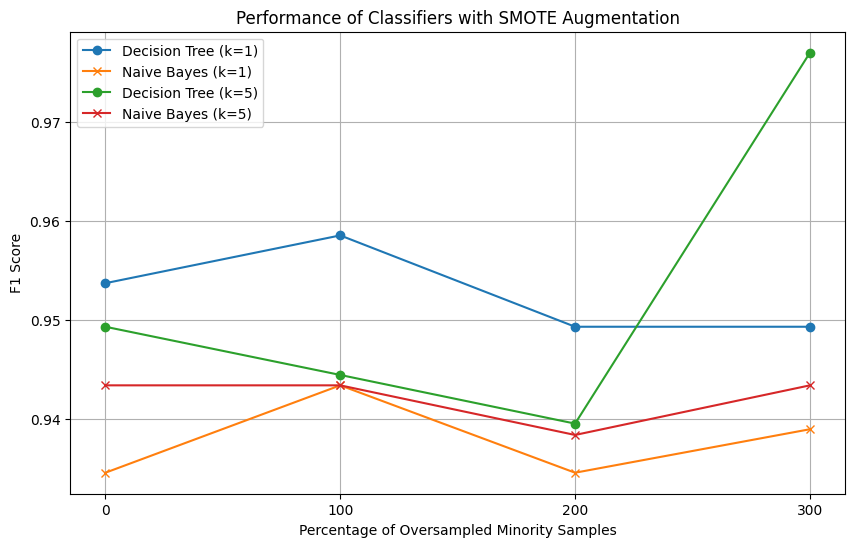

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

class SMOTE:
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors

    # SMOTE oversampling
    def fit_resample(self, X, y):
        # separate minority and majority class samples
        X_minority = X[y == 1]
        X_majority = X[y == 0]
        n_minority = len(X_minority)
        # calculate the number of synthetic samples to generate
        n_synthetic = int(0.1 * n_minority)

        synthetic_samples = []

        # iterate over each minority class sample
        for i in range(n_minority):
            sample = X_minority[i]
            # find k nearest neighbors of the minority class sample
            neighbors = self._k_nearest_neighbors(sample, X_minority, self.k_neighbors)
            # generate synthetic samples using SMOTE
            synthetic_samples.extend(self._generate_synthetic_samples(sample, neighbors, n_synthetic))

        # stack original and synthetic samples
        X_resampled = np.vstack((X, synthetic_samples))
        # create corresponding labels for resampled data
        y_resampled = np.concatenate((y, np.ones(len(synthetic_samples))))

        return X_resampled, y_resampled

    # find k nearest neighbors of a sample
    def _k_nearest_neighbors(self, sample, samples, k):
        distances = np.linalg.norm(samples - sample, axis=1)
        sorted_indices = np.argsort(distances)
        return samples[sorted_indices[1:k+1]]

    # generate synthetic samples using SMOTE
    def _generate_synthetic_samples(self, sample, neighbors, n_synthetic):
        synthetic_samples = []
        for _ in range(n_synthetic):
            neighbor = neighbors[np.random.randint(len(neighbors))]
            synthetic_sample = sample + np.random.rand() * (neighbor - sample)
            synthetic_samples.append(synthetic_sample)
        return synthetic_samples

# repasting decision tree
class DecisionTreeClassifierScratch:
    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        y = y.flatten()
        self.tree = self._build_tree(X, y)

    def _calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _calculate_information_gain(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask

        left_entropy = self._calculate_entropy(y[left_mask])
        right_entropy = self._calculate_entropy(y[right_mask])

        parent_entropy = self._calculate_entropy(y)
        weighted_child_entropy = (np.sum(left_mask) / len(y)) * left_entropy + \
                                 (np.sum(right_mask) / len(y)) * right_entropy

        information_gain = parent_entropy - weighted_child_entropy
        return information_gain

    def _find_best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_information_gain = -np.inf

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                information_gain = self._calculate_information_gain(X, y, feature_index, threshold)
                if information_gain > best_information_gain:
                    best_feature = feature_index
                    best_threshold = threshold
                    best_information_gain = information_gain

        return best_feature, best_threshold

    def _build_tree(self, X, y):
        if len(np.unique(y)) == 1:
            return {'class': np.unique(y)[0]}

        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return {'class': np.argmax(np.bincount(y))}

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        left_subtree = self._build_tree(X[left_mask], y[left_mask])
        right_subtree = self._build_tree(X[right_mask], y[right_mask])

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_subtree, 'right': right_subtree}

    def _predict_one(self, x, tree):
        while 'feature' in tree:
            if x[tree['feature']] <= tree['threshold']:
                tree = tree['left']
            else:
                tree = tree['right']
        return tree['class']

    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append(self._predict_one(x, self.tree))
        return np.array(predictions)

# repasting gaussian naive bayes
class GaussianNaiveBayesClassifierScratch:
    def __init__(self):
        self.class_probs = None
        self.means = None
        self.stds = None

    def fit(self, X, y):
        self.class_probs = {}
        self.means = {}
        self.stds = {}

        classes = np.unique(y)
        for c in classes:
            X_c = X[y == c]
            self.class_probs[c] = len(X_c) / len(X)
            self.means[c] = np.mean(X_c, axis=0)
            self.stds[c] = np.std(X_c, axis=0)

    def _calculate_probability(self, x, mean, std):
        exponent = np.exp(-((x - mean) ** 2 / (2 * std ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def _calculate_class_probability(self, x):
        probabilities = {}
        for c in self.class_probs:
            probabilities[c] = np.sum(np.log(self._calculate_probability(x, self.means[c], self.stds[c])))
        return probabilities

    def predict(self, X):
        predictions = []
        for x in X:
            probabilities = self._calculate_class_probability(x)
            prediction = max(probabilities, key=probabilities.get)
            predictions.append(prediction)
        return np.array(predictions)


# split the existing data into a random 70/30 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# percentages of oversampled minority samples
oversampling_percentages = [0, 100, 200, 300]  # 0% represents original data only

# the values of k for SMOTE
k_values = [1, 5]

# initialize lists to store F1 scores for Decision Tree and Naive Bayes
dt_f1_scores = {k: [] for k in k_values}
nb_f1_scores = {k: [] for k in k_values}

# evaluate classifiers for each oversampling percentage and each value of k
for percentage in oversampling_percentages:
    for k in k_values:
        smote = SMOTE(k_neighbors=k)
        X_train_augmented, y_train_augmented = smote.fit_resample(X_train, y_train_encoded)

        dt_classifier = DecisionTreeClassifierScratch()
        dt_classifier.fit(X_train_augmented, y_train_augmented)
        dt_pred = dt_classifier.predict(X_test)

        nb_classifier = GaussianNaiveBayesClassifierScratch()
        nb_classifier.fit(X_train_augmented, y_train_augmented)
        nb_pred = nb_classifier.predict(X_test)

        dt_f1 = f1_score(y_test_encoded, dt_pred)
        nb_f1 = f1_score(y_test_encoded, nb_pred)

        dt_f1_scores[k].append(dt_f1)
        nb_f1_scores[k].append(nb_f1)

# plot the performance of classifiers as a function of oversampling percentage for each value of k
plt.figure(figsize=(10, 6))
for k in k_values:
    plt.plot(oversampling_percentages, dt_f1_scores[k], marker='o', label=f'Decision Tree (k={k})')
    plt.plot(oversampling_percentages, nb_f1_scores[k], marker='x', label=f'Naive Bayes (k={k})')
plt.xlabel('Percentage of Oversampled Minority Samples')
plt.ylabel('F1 Score')
plt.title('Performance of Classifiers with SMOTE Augmentation')
plt.legend()
plt.grid(True)
plt.xticks(oversampling_percentages)
plt.show()
